## Setup

In [1]:
import pandas as pd

In [2]:
baseball = pd.read_csv('data/baseball.csv')
baseball = baseball.drop(['Name', 'Age', 'Name-additional'], axis = 1)
baseball['Salary'] = baseball['Salary'].str.replace('$', '').astype(float)

baseball['C'] = baseball['Position'].apply(lambda x: 1 if 'C' in x else 0)
baseball['1B'] = baseball['Position'].apply(lambda x: 1 if '1B' in x else 0)
baseball['2B'] = baseball['Position'].apply(lambda x: 1 if '2B' in x else 0)
baseball['3B'] = baseball['Position'].apply(lambda x: 1 if '3B' in x else 0)
baseball['SS'] = baseball['Position'].apply(lambda x: 1 if 'SS' in x else 0)
baseball['OF'] = baseball['Position'].apply(lambda x: 1 if 'OF' in x else 0)

baseball['Num_Pos'] = baseball[['C', '1B', '2B', '3B', 'SS', 'OF']].sum(axis = 1)
baseball = baseball.drop(['Position'], axis = 1)

In [3]:
# packages used in each section below
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

import shap
from sklearn.decomposition import PCA

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
X = baseball.drop(['Salary'], axis = 1)
y = baseball['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 621)

In [5]:
cat_columns = ['Tm', 'Lg', 'Acquired', 'Bat']
num_columns = [col for col in X.columns if col not in cat_columns + ['C', '1B', '2B', '3B', 'SS', 'OF']]

cat_transformer = Pipeline(
    steps = [
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

num_transformer = Pipeline(
    steps = [
        ('scale', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('cont', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ], remainder = 'passthrough'
)

X_transform = preprocessor.fit_transform(X)

selected_features = np.concatenate([
    np.array(num_columns),
    np.array(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(cat_columns)),
    np.array(['C', '1B', '2B', '3B', 'SS', 'OF'])
])


## Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [7]:
rfe_rf = RFE(estimator = RandomForestRegressor(random_state = 621), step = 1, n_features_to_select = None)
rfe_rf.fit(X_transform, y)

RFE(estimator=RandomForestRegressor(random_state=621))

In [8]:
selected_features[rfe_rf.support_]

array(['Def-Inn', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rdrs', 'Season', 'RAA',
       'WAA', 'RAR', 'WAR', 'PA', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'CS',
       'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP',
       'SH', 'SF', 'IBB', 'Num_Pos', 'Tm_LAA', 'Tm_LAD', 'Tm_MULTIPLE',
       'Tm_NYM', 'Tm_NYY', 'Tm_SFG', 'Tm_STL', 'Acquired_Free Agency',
       'Acquired_Traded'], dtype=object)

In [123]:
red_num_columns = ['Def-Inn', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rdrs', 'RAA', 'WAA', 'RAR',
               'WAR', 'PA', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
               'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'Num_Pos', 'Season']
red_cat_columns = ['Tm', 'Acquired']
X_rf = X[red_num_columns + red_cat_columns]

In [124]:
X_rf_red_train, X_rf_red_test, y_rf_red_train, y_rf_red_test = train_test_split(X_rf, y, test_size = .25, random_state = 621)

In [148]:
red_preprocessor = ColumnTransformer(
    transformers = [
        ('cont', num_transformer, red_num_columns),
        ('cat', cat_transformer, red_cat_columns)
    ], remainder = 'passthrough'
)

rf_red_pipe = Pipeline(
    steps = [
        ('preprocessor', red_preprocessor),
        ('model', RandomForestRegressor(n_estimators = 200, max_depth = 12, min_samples_split = 3))
    ]
)

In [149]:
rf_red_pipe.fit(X_rf_red_train, y_rf_red_train)
rf_red_train_mse = mean_squared_error(y_rf_red_train, rf_red_pipe.predict(X_rf_red_train))
rf_red_test_mse = mean_squared_error(y_rf_red_test, rf_red_pipe.predict(X_rf_red_test))
print('Reduced Random Forest Metrics:')
print(f'Training RMSE: {np.sqrt(rf_red_train_mse)}')
print(f'Test RMSE: {np.sqrt(rf_red_test_mse)}')

Reduced Random Forest Metrics:
Training RMSE: 2665873.0847510966
Test RMSE: 5328864.974109751


In [116]:
rf_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators = 200, min_samples_split = 14))
    ]
)

In [117]:
rf_pipe.fit(X_train, y_train)
rf_train_mse = mean_squared_error(y_train, rf_pipe.predict(X_train))
rf_test_mse = mean_squared_error(y_test, rf_pipe.predict(X_test))
print('Random Forest Metrics:')
print(f'Training RMSE: {np.sqrt(rf_train_mse)}')
print(f'Test RMSE: {np.sqrt(rf_test_mse)}')

Random Forest Metrics:
Training RMSE: 2995640.073838007
Test RMSE: 5339371.913062029


## XGBoost 

In [15]:
from xgboost import XGBRegressor

In [16]:
rfe_xg = RFE(estimator = XGBRegressor(random_state = 621), step = 1, n_features_to_select = None)
rfe_xg.fit(X_transform, y)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, early_stopping_rounds=None,
                           enable_categorical=False, eval_metric=None,
                           feature_types=None, gamma=None, gpu_id=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None, predictor=None,
                           random_state=621, ...))

In [17]:
selected_features[rfe_xg.support_]

array(['Season', 'RBI', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS+',
       'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'Num_Pos', 'Tm_ARI',
       'Tm_BOS', 'Tm_CHC', 'Tm_CIN', 'Tm_DET', 'Tm_HOU', 'Tm_KCR',
       'Tm_LAA', 'Tm_LAD', 'Tm_MIA', 'Tm_MIN', 'Tm_MULTIPLE', 'Tm_NYM',
       'Tm_NYY', 'Tm_OAK', 'Tm_PHI', 'Tm_STL', 'Tm_TBR', 'Tm_TEX',
       'Acquired_Amateur Draft', 'Acquired_Amateur Free Agent',
       'Acquired_Free Agency', 'Acquired_Traded', 'Bat_L', 'Bat_R', '1B',
       '2B'], dtype=object)

In [18]:
red_num_columns = ['Season', 'RBI', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS+', 
                   'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'Num_Pos']
red_cat_columns = ['Tm', 'Acquired', 'Bat', 'C', '1B', '2B', '3B', 'SS', 'OF']
X_xg = X[red_num_columns + red_cat_columns]

In [19]:
X_xg_red_train, X_xg_red_test, y_xg_red_train, y_xg_red_test = train_test_split(X_xg, y, test_size = .25, random_state = 621)

In [71]:
red_preprocessor = ColumnTransformer(
    transformers = [
        ('cont', num_transformer, red_num_columns),
        ('cat', cat_transformer, red_cat_columns)
    ], remainder = 'passthrough'
)

xg_red_pipe = Pipeline(
    steps = [
        ('preprocessor', red_preprocessor),
        ('model', XGBRegressor(n_estimators = 200, learning_rate = .06, max_depth = 5))
    ]
)

In [72]:
xg_red_pipe.fit(X_xg_red_train, y_xg_red_train)
xg_red_train_mse = mean_squared_error(y_xg_red_train, xg_red_pipe.predict(X_xg_red_train))
xg_red_test_mse = mean_squared_error(y_xg_red_test, xg_red_pipe.predict(X_xg_red_test))
print('Reduced XGBoost Metrics:')
print(f'Training RMSE: {np.sqrt(xg_red_train_mse)}')
print(f'Test RMSE: {np.sqrt(xg_red_test_mse)}')

Reduced Random Forest Metrics:
Training RMSE: 3174834.536729983
Test RMSE: 5035866.184550909


In [155]:
xg_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators = 100, learning_rate = .03, max_depth = 6))
    ]
)

In [156]:
xg_pipe.fit(X_train, y_train)
xg_train_mse = mean_squared_error(y_train, xg_pipe.predict(X_train))
xg_test_mse = mean_squared_error(y_test, xg_pipe.predict(X_test))
print('XGBoost Metrics:')
print(f'Training RMSE: {np.sqrt(xg_train_mse)}')
print(f'Test RMSE: {np.sqrt(xg_test_mse)}')

Random Forest Metrics:
Training RMSE: 3537922.5378611186
Test RMSE: 5184611.048067813


## Gradient Boosting

In [157]:
from sklearn.ensemble import GradientBoostingRegressor

In [158]:
rfe_gb = RFE(estimator = GradientBoostingRegressor(random_state = 621), step = 1, n_features_to_select = None)
rfe_gb.fit(X_transform, y)

RFE(estimator=GradientBoostingRegressor(random_state=621))

In [159]:
selected_features[rfe_gb.support_]

array(['Def-Inn', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rdrs', 'Season', 'RAA',
       'WAA', 'RAR', 'WAR', 'PA', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'CS',
       'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'SH',
       'SF', 'IBB', 'Num_Pos', 'Tm_LAA', 'Tm_LAD', 'Tm_MIN',
       'Tm_MULTIPLE', 'Tm_NYY', 'Tm_OAK', 'Tm_STL',
       'Acquired_Free Agency', 'Acquired_Traded', '2B'], dtype=object)

In [160]:
red_num_columns = ['Def-Inn', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rdrs', 'Season', 'RAA',
       'WAA', 'RAR', 'WAR', 'PA', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'CS',
       'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'SH',
       'SF', 'IBB', 'Num_Pos']
red_cat_columns = ['Tm', 'Acquired', 'C', '1B', '2B', '3B', 'SS', 'OF']
X_gb = X[red_num_columns + red_cat_columns]

In [161]:
X_gb_red_train, X_gb_red_test, y_gb_red_train, y_gb_red_test = train_test_split(X_gb, y, test_size = .25, random_state = 621)

In [196]:
red_preprocessor = ColumnTransformer(
    transformers = [
        ('cont', num_transformer, red_num_columns),
        ('cat', cat_transformer, red_cat_columns)
    ], remainder = 'passthrough'
)

gb_red_pipe = Pipeline(
    steps = [
        ('preprocessor', red_preprocessor),
        ('model', GradientBoostingRegressor(learning_rate = 0.075, n_estimators = 200, max_depth = 4))
    ]
)

In [197]:
gb_red_pipe.fit(X_gb_red_train, y_gb_red_train)
gb_red_train_mse = mean_squared_error(y_gb_red_train, gb_red_pipe.predict(X_gb_red_train))
gb_red_test_mse = mean_squared_error(y_gb_red_test, gb_red_pipe.predict(X_gb_red_test))
print('Reduced Gradient Boosting Metrics:')
print(f'Training RMSE: {np.sqrt(gb_red_train_mse)}')
print(f'Test RMSE: {np.sqrt(gb_red_test_mse)}')

Reduced Random Forest Metrics:
Training RMSE: 3426537.951924427
Test RMSE: 5028275.917521109


In [200]:
gb_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(learning_rate = 0.075, n_estimators = 200, max_depth = 4))
    ]
)

In [201]:
gb_pipe.fit(X_train, y_train)
gb_train_mse = mean_squared_error(y_train, gb_pipe.predict(X_train))
gb_test_mse = mean_squared_error(y_test, gb_pipe.predict(X_test))
print('Gradient Boosting Metrics:')
print(f'Training RMSE: {np.sqrt(gb_train_mse)}')
print(f'Test RMSE: {np.sqrt(gb_test_mse)}')

Random Forest Metrics:
Training RMSE: 3379850.3723368607
Test RMSE: 5028062.821060685


## ADA Boosting

In [202]:
from sklearn.ensemble import AdaBoostRegressor

In [203]:
rfe_ada = RFE(estimator = AdaBoostRegressor(random_state = 621), step = 1, n_features_to_select = None)
rfe_ada.fit(X_transform, y)

RFE(estimator=AdaBoostRegressor(random_state=621))

In [204]:
selected_features[rfe_ada.support_]

array(['Def-Inn', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rdrs', 'Season', 'RAA',
       'WAA', 'RAR', 'WAR', 'PA', 'AB', 'R', 'H', 'HR', 'RBI', 'CS', 'BB',
       'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'GDP', 'HBP', 'SH', 'SF',
       'IBB', 'Num_Pos', 'Tm_CHC', 'Tm_COL', 'Tm_DET', 'Tm_HOU', 'Tm_LAA',
       'Tm_NYM', 'Tm_NYY', 'Acquired_Free Agency', 'Bat_L', 'Bat_R', '2B'],
      dtype=object)

In [205]:
red_num_columns = ['Def-Inn', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rdrs', 'Season', 'RAA', 'WAA',
       'RAR', 'WAR', 'PA', 'AB', 'R', 'H', 'HR', 'RBI', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'OPS+', 'GDP', 'HBP', 'SH', 'SF', 'IBB',
       'Num_Pos']
red_cat_columns = ['Tm', 'Acquired', 'Bat', 'C', '1B', '2B', '3B', 'SS', 'OF']
X_ada = X[red_num_columns + red_cat_columns]

In [206]:
X_ada_red_train, X_ada_red_test, y_ada_red_train, y_ada_red_test = train_test_split(X_ada, y, test_size = .25, random_state = 621)

In [246]:
red_preprocessor = ColumnTransformer(
    transformers = [
        ('cont', num_transformer, red_num_columns),
        ('cat', cat_transformer, red_cat_columns)
    ], remainder = 'passthrough'
)

ada_red_pipe = Pipeline(
    steps = [
        ('preprocessor', red_preprocessor),
        ('model', AdaBoostRegressor(n_estimators = 200, learning_rate = 0.01))
    ]
)

In [247]:
ada_red_pipe.fit(X_ada_red_train, y_ada_red_train)
ada_red_train_mse = mean_squared_error(y_ada_red_train, ada_red_pipe.predict(X_ada_red_train))
ada_red_test_mse = mean_squared_error(y_ada_red_test, ada_red_pipe.predict(X_ada_red_test))
print('Reduced ADABoost Metrics:')
print(f'Training RMSE: {np.sqrt(ada_red_train_mse)}')
print(f'Test RMSE: {np.sqrt(ada_red_test_mse)}')

Reduced Random Forest Metrics:
Training RMSE: 5358808.636299628
Test RMSE: 5656509.686938622


In [252]:
ada_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 30)),
        ('model', AdaBoostRegressor(n_estimators = 200, learning_rate = 0.01))
    ]
)

In [253]:
ada_pipe.fit(X_train, y_train)
ada_train_mse = mean_squared_error(y_train, ada_pipe.predict(X_train))
ada_test_mse = mean_squared_error(y_test, ada_pipe.predict(X_test))
print('ADABoost Metrics:')
print(f'Training RMSE: {np.sqrt(ada_train_mse)}')
print(f'Test RMSE: {np.sqrt(ada_test_mse)}')

Random Forest Metrics:
Training RMSE: 5528645.110368226
Test RMSE: 5866138.083422676


## Support Vector Machine

In [254]:
from sklearn.svm import SVC

In [263]:
svm_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', SVC(C = 3))
    ]
)

In [264]:
svm_pipe.fit(X_train, y_train)
svm_train_mse = mean_squared_error(y_train, svm_pipe.predict(X_train))
svm_test_mse = mean_squared_error(y_test, svm_pipe.predict(X_test))
print('Support Vector Machine Metrics:')
print(f'Training RMSE: {np.sqrt(svm_train_mse)}')
print(f'Test RMSE: {np.sqrt(svm_test_mse)}')

Random Forest Metrics:
Training RMSE: 3305791.485725613
Test RMSE: 6511994.651652397


## KNN

In [265]:
from sklearn.neighbors import KNeighborsRegressor

In [290]:
knn_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 63)),
        ('model', KNeighborsRegressor(n_neighbors = 5, weights = 'uniform'))
    ]
)

In [291]:
knn_pipe.fit(X_train, y_train)
knn_train_mse = mean_squared_error(y_train, knn_pipe.predict(X_train))
knn_test_mse = mean_squared_error(y_test, knn_pipe.predict(X_test))
print('K-Nearest Neighbors Metrics:')
print(f'Training RMSE: {np.sqrt(knn_train_mse)}')
print(f'Test RMSE: {np.sqrt(knn_test_mse)}')

Random Forest Metrics:
Training RMSE: 4357478.9227963155
Test RMSE: 5627354.873436867


## SHAP

In [450]:
import shap
import tensorflow as tf
from keras.models import load_model

In [468]:
dnn = load_model('dnn/dnn_model.keras')
#pca = joblib.load('dnn/pca45.joblib')
prep = joblib.load('dnn/dnn_preprocssor.joblib')

In [469]:
X_prep = prep.transform(X)
#X_pca = pca.transform(X_prep)

In [470]:
predictions = dnn.predict(X_prep)

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [472]:
explainer = shap.Explainer(dnn, X_prep)

In [473]:
shap_values = explainer.shap_values(X_prep)

Permutation explainer: 5062it [23:38,  3.55it/s]                          


In [474]:
expected_value = dnn.predict(X_prep).mean()

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [475]:
exp = shap.Explanation(shap_values, expected_value, X_prep, feature_names = prep.get_feature_names_out())

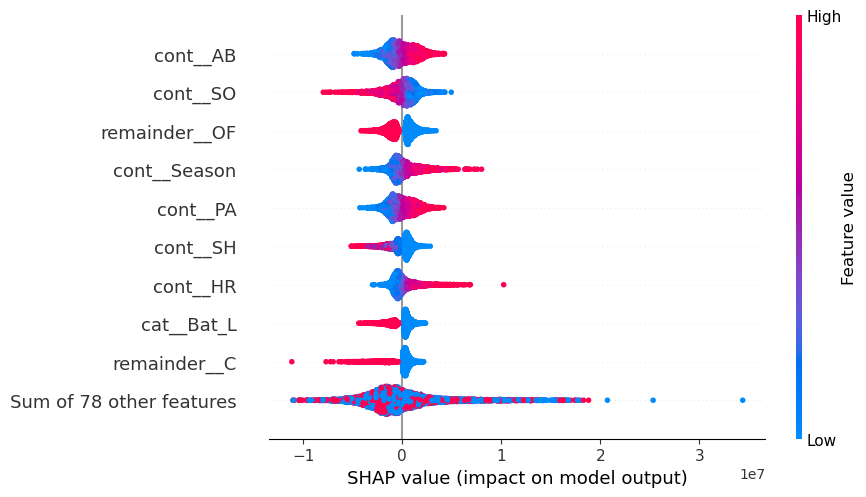

In [476]:
shap.plots.beeswarm(exp)